In [16]:
import os
import librosa   #thư viện xủ lý tín hiệu âm thanh
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #để đọc file wav 
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

train_audio_path = 'D:/DATA/voice/train/audio/'
labels=os.listdir(train_audio_path)

In [5]:
from numpy import save
from numpy import asarray

WORD = 6000
WORD_HALF = int(WORD/2)
CHUNK = 10000 
all_wave = []
all_label = []
all_feature = []
for label in labels:
    print("Label:",label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 16000)
        
        leng = len(samples)
        chunk_count = int(leng/CHUNK)
        word_count = 0
        for i in range(0,chunk_count):
            data = samples[i*CHUNK:(i+2)*CHUNK]
            mean = np.mean(data)
            energy = abs(data)
            value = 0
            max_val = 0
            max_idn = 0
            for idn in range(0,len(energy)):
                value += (energy[idn]-value)/1000
                if (idn>WORD_HALF) & (idn<(len(data)-WORD_HALF )):
                    if max_val<value:
                        max_val = value
                        max_idn = idn
            if max_val>(mean*4):
                word_count = word_count+1
                data = data[max_idn-WORD_HALF:max_idn+WORD_HALF]
#                 feature_vector = librosa.feature.melspectrogram(y=data, sr=16000)[:40]
#                 feature_vector = librosa.feature.chroma_stft(y=data, sr=16000)
                all_wave.append(data)
#                 all_feature.append(feature_vector)
                all_label.append(label)
#         print(chunk_count," ",word_count)
save('all_wave', all_wave)
#save('all_feature', all_feature)
save('all_label', all_label)

Label: 0
Label: 1
Label: 2


KeyboardInterrupt: 

In [ ]:
#test code
testId = 70
energy = abs(all_wave[testId])
mean =np.mean(energy)
value = 0
max_val = 0
max_idn = 0
for idn in range(0,len(energy)):
    value += (energy[idn]-value)/1000
    if max_val<value:
        max_val = value
        max_idn = idn
plt.plot(energy)
print(max_idn)
print(max_val/mean)
# mean = np.mean(energy)*2
# cfar = [1 if e > mean else 0 for e in energy]
# plt.plot(cfar)

In [11]:
import matplotlib.pyplot as plt
import librosa.display

from numpy import load
from numpy import save
from numpy import asarray

all_wave = load('all_wave.npy')
# 
all_label = load('all_label.npy')
all_feature=[]
for word in all_wave:
    feature_vector_1 = librosa.feature.chroma_stft(y=word, sr=16000)
    feature_vector_2 = librosa.feature.melspectrogram(y=word, sr=16000)[:40]
    feature_vector = np.concatenate((feature_vector_1*10,feature_vector_2))
    all_feature.append(feature_vector)


In [10]:
feature_vector_2

array([[ 3.742985 ,  9.911686 , 13.352017 , 10.018255 ,  7.5922613,
         5.250971 ,  6.94084  , 10.084034 , 15.798138 ,  9.79271  ,
        31.64447  , 22.43475  ],
       [ 2.3994627,  5.429068 , 17.218248 ,  9.713057 ,  3.4737468,
         7.900267 ,  7.4334855, 18.799294 , 19.570372 ,  8.966624 ,
        14.944537 , 18.500784 ],
       [ 6.0580535,  9.175926 ,  9.428867 ,  6.730262 ,  7.873058 ,
         5.8930917,  9.05002  ,  9.593072 ,  8.852078 , 19.578281 ,
        14.29771  ,  3.5988202],
       [11.1454735,  9.555058 , 15.806781 , 13.268841 , 10.87718  ,
         7.3093834,  6.989197 ,  5.4766994,  7.277533 ,  6.634409 ,
         6.1043496,  5.7188125],
       [ 9.751096 , 11.434927 , 26.152092 , 24.307259 ,  4.2110167,
         2.395006 ,  8.483662 ,  8.605051 , 12.70681  , 12.392631 ,
        10.345757 , 11.997699 ],
       [17.952316 , 12.999842 , 11.548295 , 13.051687 , 11.544039 ,
        23.025406 , 34.1893   , 16.07576  , 24.682428 , 28.78652  ,
         9.613479 ,

5


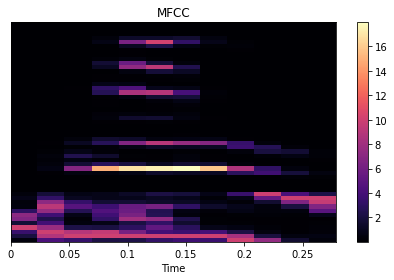

In [12]:

testId = 1082
print(all_label[testId])
feature_vector = all_feature[testId]

# plt.figure(figsize=(20, 4))
# librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('melspectrogram')
# plt.tight_layout()
# plt.show()
librosa.display.specshow(feature_vector, x_axis='time') 
plt.colorbar() 
plt.title('MFCC') 
plt.tight_layout()
ipd.Audio(all_wave[testId], rate=16000)

In [13]:
len(all_feature)

2165

In [29]:
#data preprocessing
labels=os.listdir(train_audio_path)
from sklearn.preprocessing import LabelEncoder
all_feature = np.array(all_feature)
feature_vector = all_feature[0]
print(all_feature.shape)
feature_size = feature_vector.shape

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
all_feature = np.array(all_feature).reshape(-1,feature_size[0],feature_size[1],1)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_feature),np.array(y),stratify=y,test_size = 0.1,random_state=555,shuffle=True)

(2165, 52, 12, 1)


In [19]:
y_tr.shape

(1948, 11)

In [ ]:
x_tr.shape

In [30]:
#thiết kế mô hình deep learning
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model1 = Sequential()

model1.add(Conv2D(16, kernel_size=(3, 3), strides= (2, 2), padding='same',data_format='channels_last',input_shape=(feature_size[0], feature_size[1],1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, kernel_size=(3, 3), strides= (1, 1), padding='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# model1.add(Conv2D(64, kernel_size=(3, 3), strides= (1, 1), padding='same'))
# model1.add(LeakyReLU(alpha=0.1))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dropout(0.1))
model1.add(Dense(11))
model1.add(Activation('softmax'))
optimizer = Adam(lr=0.005)
opt = SGD(lr=0.005, momentum=0.9)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 6, 16)         160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 26, 6, 16)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 3, 16)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 3, 32)         4640      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 13, 3, 32)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 1, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)              

In [31]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,
                    epochs=250,
                    batch_size=200)

Epoch 1/250
1948/1948 [==============================] - 0s 92us/step - loss: 2.7392 - accuracy: 0.1704
Epoch 2/250
1948/1948 [==============================] - 0s 59us/step - loss: 2.2048 - accuracy: 0.2377
Epoch 3/250
1948/1948 [==============================] - 0s 59us/step - loss: 2.0713 - accuracy: 0.2977
Epoch 4/250
1948/1948 [==============================] - 0s 59us/step - loss: 1.9352 - accuracy: 0.3676
Epoch 5/250
1948/1948 [==============================] - 0s 56us/step - loss: 1.7315 - accuracy: 0.4779
Epoch 6/250
1948/1948 [==============================] - 0s 56us/step - loss: 1.4763 - accuracy: 0.5672
Epoch 7/250
1948/1948 [==============================] - 0s 53us/step - loss: 1.2559 - accuracy: 0.6181
Epoch 8/250
1948/1948 [==============================] - 0s 56us/step - loss: 1.1573 - accuracy: 0.6068
Epoch 9/250
1948/1948 [==============================] - 0s 57us/step - loss: 1.0021 - accuracy: 0.6792
Epoch 10/250
1948/1948 [==============================] - 0s 60u

1948/1948 [==============================] - 0s 56us/step - loss: 0.1145 - accuracy: 0.9671
Epoch 80/250
1948/1948 [==============================] - 0s 56us/step - loss: 0.1141 - accuracy: 0.9687
Epoch 81/250
1948/1948 [==============================] - 0s 54us/step - loss: 0.1206 - accuracy: 0.9656
Epoch 82/250
1948/1948 [==============================] - 0s 60us/step - loss: 0.1083 - accuracy: 0.9723
Epoch 83/250
1948/1948 [==============================] - 0s 59us/step - loss: 0.1031 - accuracy: 0.9702
Epoch 84/250
1948/1948 [==============================] - 0s 57us/step - loss: 0.1087 - accuracy: 0.9671
Epoch 85/250
1948/1948 [==============================] - 0s 54us/step - loss: 0.1137 - accuracy: 0.9656
Epoch 86/250
1948/1948 [==============================] - 0s 57us/step - loss: 0.1108 - accuracy: 0.9692
Epoch 87/250
1948/1948 [==============================] - 0s 54us/step - loss: 0.2764 - accuracy: 0.9363
Epoch 88/250
1948/1948 [==============================] - 0s 56us/st

1948/1948 [==============================] - 0s 55us/step - loss: 0.0503 - accuracy: 0.9872
Epoch 157/250
1948/1948 [==============================] - 0s 56us/step - loss: 0.0507 - accuracy: 0.9872
Epoch 158/250
1948/1948 [==============================] - 0s 54us/step - loss: 0.0525 - accuracy: 0.9867
Epoch 159/250
1948/1948 [==============================] - 0s 57us/step - loss: 0.0507 - accuracy: 0.9897
Epoch 160/250
1948/1948 [==============================] - 0s 53us/step - loss: 0.0490 - accuracy: 0.9856
Epoch 161/250
1948/1948 [==============================] - 0s 60us/step - loss: 0.0503 - accuracy: 0.9877
Epoch 162/250
1948/1948 [==============================] - 0s 53us/step - loss: 0.0446 - accuracy: 0.9887
Epoch 163/250
1948/1948 [==============================] - 0s 60us/step - loss: 0.0437 - accuracy: 0.9882
Epoch 164/250
1948/1948 [==============================] - 0s 55us/step - loss: 0.0457 - accuracy: 0.9892
Epoch 165/250
1948/1948 [==============================] - 0

1948/1948 [==============================] - 0s 58us/step - loss: 0.0250 - accuracy: 0.9938
Epoch 234/250
1948/1948 [==============================] - 0s 58us/step - loss: 0.0229 - accuracy: 0.9949
Epoch 235/250
1948/1948 [==============================] - 0s 55us/step - loss: 0.0270 - accuracy: 0.9923
Epoch 236/250
1948/1948 [==============================] - 0s 56us/step - loss: 0.0313 - accuracy: 0.9913
Epoch 237/250
1948/1948 [==============================] - 0s 52us/step - loss: 0.0250 - accuracy: 0.9923
Epoch 238/250
1948/1948 [==============================] - 0s 54us/step - loss: 0.0275 - accuracy: 0.9928
Epoch 239/250
1948/1948 [==============================] - 0s 53us/step - loss: 0.0224 - accuracy: 0.9949
Epoch 240/250
1948/1948 [==============================] - 0s 58us/step - loss: 0.0265 - accuracy: 0.9944
Epoch 241/250
1948/1948 [==============================] - 0s 55us/step - loss: 0.0208 - accuracy: 0.9959
Epoch 242/250
1948/1948 [==============================] - 0

In [33]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,
                    epochs=5,
                    batch_size=300)

Epoch 1/5
1948/1948 [==============================] - 0s 61us/step - loss: 0.0204 - accuracy: 0.9949
Epoch 2/5
1948/1948 [==============================] - 0s 56us/step - loss: 0.0289 - accuracy: 0.9933
Epoch 3/5
1948/1948 [==============================] - 0s 57us/step - loss: 0.0240 - accuracy: 0.9938
Epoch 4/5
1948/1948 [==============================] - 0s 55us/step - loss: 0.0234 - accuracy: 0.9949
Epoch 5/5
1948/1948 [==============================] - 0s 57us/step - loss: 0.0198 - accuracy: 0.9974


In [36]:
#kiểm tra mô hình sau khi luyện
for idn in range(0,800):
    output = model1.predict(all_feature)[idn]
    indexMax = np.argmax(output, axis=0) 
    if  int(all_label[idn]) != indexMax:
        print ( "id:",idn," prediction:",indexMax," value:", output[indexMax])
        print ("truth:",all_label[idn])
        
#     ipd.Audio(all_wave[testId], rate=16000)

KeyboardInterrupt: 

In [38]:
ipd.Audio(all_wave[80], rate=16000)

In [ ]:
all_label[idn]

In [ ]:
all_label[40]

In [39]:
# lưu kiến trúc của model đã luyện vào file json
model_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# lưu các trọng số của model
model1.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
